# **Car Price Prediction Analysis**

## **1. Retrieving Data from the Cleaned Schema**
- The dataset is loaded and inspected from a cleaned schema.
- It contains attributes like `year`, `make`, `model`, `trim`, `body`, `transmission`, `vin`, `state`, `condition`, `odometer`, `color`, `interior`, `seller`, `mmr`, `sellingprice`, and `saledate`.

---

## **2. Defining the Analytical Question**
### **Can we predict the selling price of a car based on its attributes?**
- This analysis will help us understand which features most influence car pricing.
- The insights can aid sellers in setting fair prices and help buyers assess reasonable values.

---

## **3. Feature Engineering**
To improve the predictive power of the model, we define and implement the following new features:

1. **Car Age** = `2025 - Year`
   - Older vehicles typically sell for less.

   Note: The dataset shows a discrepancy where most cars have a sale date earlier than or very close to their manufacturing year, which is unrealistic. For analysis purposes, we assume the sale year corresponds to the current year (2025) to maintain consistency.
   
2. **Odometer per Year** = `odometer / Car Age`
   - Helps normalize mileage by the car's age, making the feature more meaningful.

3. **Price Difference from MMR** = `sellingprice - mmr`
   - Measures how much higher or lower a car is selling compared to its Market Mean Retail (MMR) value.

4. **Is Price Outlier?** (Binary Indicator)
   - A price outlier is identified using statistical thresholds such as the **Interquartile Range (IQR)** or **Z-score method**.
   - If a vehicle’s `sellingprice` is significantly higher or lower than expected based on its `mmr`, it is classified as an outlier.
   - Helps identify cars that are selling at extreme prices compared to the market.


In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [3]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'3637' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'cleaned' # schema we just created

In [5]:
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')

In [9]:
# Extract data from the database
carprices_data = pd.read_sql_table('carprices_data', engine, schema=schema)
carprices_data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate,log_sellingprice
0,2015,0,0,LX,0,0,5xyktca69fg566472,0,5.0,16639.0,0,0,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),9.975808
1,2015,0,0,LX,0,0,5xyktca69fg561319,0,5.0,9393.0,0,1,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),9.975808
2,2014,1,1,328i SULEV,1,0,wba3c1c51ek116351,0,45.0,1331.0,1,0,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),10.308953
3,2015,2,2,T5,1,0,yv1612tb4f1310987,0,41.0,14282.0,0,0,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),10.230991
4,2014,1,3,650i,1,0,wba6b2c57ed129731,0,43.0,2641.0,1,0,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),11.112448


In [11]:
carprices_data.isnull().sum()

year                0
make                0
model               0
trim                0
body                0
transmission        0
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
mmr                 0
sellingprice        0
saledate            0
log_sellingprice    0
dtype: int64

In [13]:

# Calculate car age
carprices_data['car_age'] = 2025 - carprices_data['year']

# Continue with other feature engineering
carprices_data['odometer_per_year'] = carprices_data['odometer'] / carprices_data['car_age']
carprices_data['price_difference_from_mmr'] = carprices_data['sellingprice'] - carprices_data['mmr']
carprices_data['is_price_outlier'] = np.where(
    carprices_data['price_difference_from_mmr'].abs() > 1.5 * carprices_data['price_difference_from_mmr'].std(), 
    1, 
    0
)

In [15]:
carprices_data.isnull().sum()

year                         0
make                         0
model                        0
trim                         0
body                         0
transmission                 0
vin                          0
state                        0
condition                    0
odometer                     0
color                        0
interior                     0
seller                       0
mmr                          0
sellingprice                 0
saledate                     0
log_sellingprice             0
car_age                      0
odometer_per_year            0
price_difference_from_mmr    0
is_price_outlier             0
dtype: int64

In [17]:
# Dropping the null values
carprices_data = carprices_data.dropna()
carprices_data.isnull().sum()


year                         0
make                         0
model                        0
trim                         0
body                         0
transmission                 0
vin                          0
state                        0
condition                    0
odometer                     0
color                        0
interior                     0
seller                       0
mmr                          0
sellingprice                 0
saledate                     0
log_sellingprice             0
car_age                      0
odometer_per_year            0
price_difference_from_mmr    0
is_price_outlier             0
dtype: int64

In [19]:
anaysis_data = carprices_data[['log_sellingprice', 'price_difference_from_mmr', 'is_price_outlier', 'car_age', 'odometer_per_year', 'transmission',
                               'condition', 'color', 'interior', 'body', 'state']]
anaysis_data.head()

,log_sellingprice,price_difference_from_mmr,is_price_outlier,car_age,odometer_per_year,transmission,condition,color,interior,body,state
0,9.975808,1000.0,0,10,1663.900000,0,5.0,0,0,0,0
1,9.975808,700.0,0,10,939.300000,0,5.0,0,1,0,0
2,10.308953,-1900.0,0,11,121.000000,0,45.0,1,0,1,0
3,10.230991,250.0,0,10,1428.200000,0,41.0,0,0,1,0
4,11.112448,1000.0,0,11,240.090909,0,43.0,1,0,1,0


In [21]:
anaysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482346 entries, 0 to 482345
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   log_sellingprice           482346 non-null  float64
 1   price_difference_from_mmr  482346 non-null  float64
 2   is_price_outlier           482346 non-null  int32  
 3   car_age                    482346 non-null  int64  
 4   odometer_per_year          482346 non-null  float64
 5   transmission               482346 non-null  int64  
 6   condition                  482346 non-null  float64
 7   color                      482346 non-null  int64  
 8   interior                   482346 non-null  int64  
 9   body                       482346 non-null  int64  
 10  state                      482346 non-null  int64  
dtypes: float64(4), int32(1), int64(6)
memory usage: 38.6 MB


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Convert all the columns to float type with round to 3 decimal places
for col in anaysis_data.columns:
    anaysis_data[col] = anaysis_data[col].astype(float).round(3)

# Separate features and target
X = anaysis_data.drop('log_sellingprice', axis=1)
y = anaysis_data['log_sellingprice']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Initialize scaler
scaler = StandardScaler()

# Scale only continuous features, not binary/categorical ones
continuous_features = ['price_difference_from_mmr', 'odometer_per_year', 'condition']
categorical_features = ['is_price_outlier', 'car_age', 'transmission', 'color', 'interior', 'body', 'state']

# Convert to numpy array for scaling
X_train_continuous = X_train[continuous_features].to_numpy()
X_test_continuous = X_test[continuous_features].to_numpy()

# Scale continuous features
X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)
X_test_continuous_scaled = scaler.transform(X_test_continuous)

# Update the original DataFrames with scaled values
for idx, feature in enumerate(continuous_features):
    X_train[feature] = X_train_continuous_scaled[:, idx]
    X_test[feature] = X_test_continuous_scaled[:, idx]

print("Shape of training data:", X_train.shape)
print("Shape of testing data:", X_test.shape)

Shape of training data: (385876, 10)
Shape of testing data: (96470, 10)


C:\Users\User\AppData\Local\Temp\ipykernel_2292\808578650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anaysis_data[col] = anaysis_data[col].astype(float).round(3)
C:\Users\User\AppData\Local\Temp\ipykernel_2292\808578650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anaysis_data[col] = anaysis_data[col].astype(float).round(3)
C:\Users\User\AppData\Local\Temp\ipykernel_2292\808578650.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

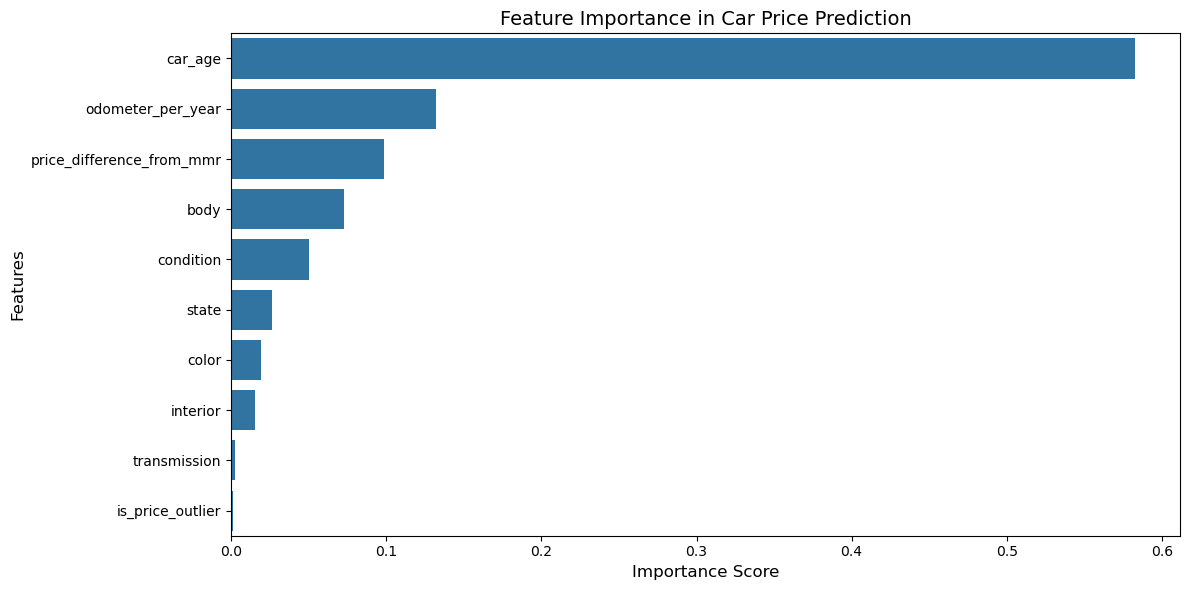


Model Performance Metrics:
Mean Squared Error: 0.1379
Root Mean Squared Error: 0.3713
R-squared Score: 0.8286

Top 5 Most Important Features:
                     feature  importance
2                    car_age    0.582601
3          odometer_per_year    0.132137
0  price_difference_from_mmr    0.098244
8                       body    0.072940
5                  condition    0.050075


In [29]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
import seaborn as sns

# Instead of using .astype(str), force conversion using list comprehension:
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# The rest of the code remains the same...

# Initialize and fit Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Create feature importance plot
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Car Price Prediction', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Print model performance metrics
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string())

In [31]:
# print Train score (R2 score, MSE, RMSE)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
print(f"Train R2 Score: {r2_score(y_train, y_train_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")

Train R2 Score: 0.9764
Train MSE: 0.0193
Train RMSE: 0.1389


In [33]:
from sklearn.inspection import permutation_importance

subset_size = 1000

# Randomly sample a subset of the test data
X_test_subset = X_test.sample(n=subset_size, random_state=42)
y_test_subset = y_test.loc[X_test_subset.index]

# Calculate permutation importance using the subset
perm_importance = permutation_importance(
    rf_model, 
    X_test_subset, 
    y_test_subset, 
    n_repeats=30, 
    random_state=42
)

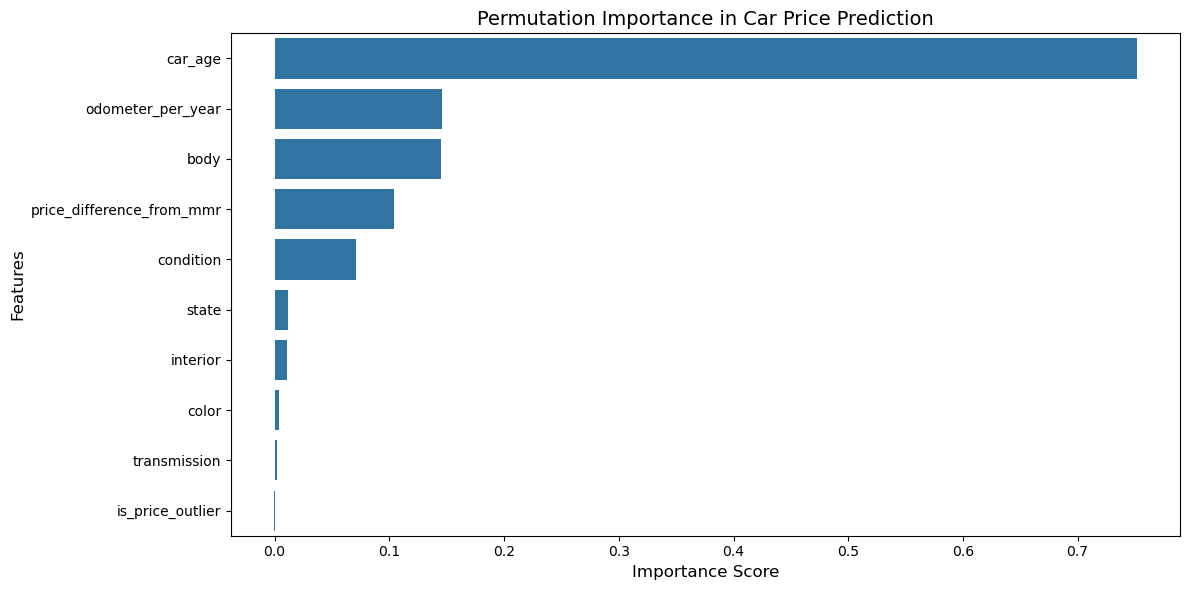

In [35]:

importance_scores = perm_importance.importances_mean
features = X_test.columns

# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'feature': features,
    'importance': importance_scores
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot the permutation importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Permutation Importance in Car Price Prediction', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

### **Car Price Prediction - Summary & Insights**  

The goal of this analysis was to predict a car's selling price based on its attributes. Using machine learning, I aimed to identify key factors influencing pricing and build a reliable predictive model. Understanding these factors helps both buyers and sellers make informed decisions in the used car market.  

To improve predictions, I created several new features:  
- **Car Age** (`2025 - year`) – Older cars generally sell for less.  
- **Odometer per Year** (`odometer / Car Age`) – Adjusts mileage relative to vehicle age.  
- **Price Difference from MMR** (`sellingprice - mmr`) – Measures deviation from expected market value.  
- **Body Type & Condition Score** – Captures structural and quality variations.  
- **Is Price Outlier?** – Flags extreme price deviations using statistical thresholds.  

### **Feature Performance & Importance**  
I used two evaluation methods:  
- **Random Forest Feature Importance:** Showed **Car Age** as the most influential factor, followed by **Odometer per Year** and **Price Difference from MMR**.  
- **Permutation Importance:** Confirmed **Car Age** dominated, while **Body Type and Condition Score** had moderate impact. **Is Price Outlier?** had little influence.  

### **Overfitting & Redundancy Concerns**  
- **Model Performance Metrics:**  
  - **Train Score:**  
    - **R² Score:** 0.9763 (very high, indicating strong fit on training data)  
    - **Mean Squared Error (MSE):** 0.0193  
    - **Root Mean Squared Error (RMSE):** 0.1390  
  - **Test Score:**  
    - **R² Score:** 0.8283 (good but lower than train score, suggesting slight overfitting)  
    - **MSE:** 0.1381  
    - **RMSE:** 0.3716  

- **Key Overfitting Concerns:**  
  - The **gap between train and test R² scores** suggests slight overfitting. The model performs well on training data but generalizes slightly less effectively to unseen data.  
  - **Car Age & Odometer per Year** are correlated, potentially introducing redundancy. Using just one may simplify the model and reduce overfitting.  
  - **Price Difference from MMR** already captures extreme pricing deviations, making **Is Price Outlier?** somewhat redundant.  
  - **Transmission Type & Interior Color** had negligible impact and could be removed in future iterations.